In [1]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import tfim_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

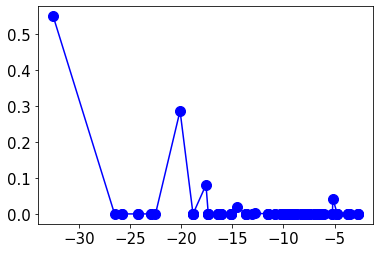

[0.55068588]


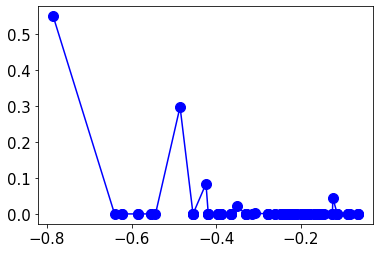

In [2]:
num_sites = 8
J = 1.0
g = 4.0

num_eigenstates_max = 100

ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

ham = tfim_1d.generate_ham(num_sites, J, g)
if( num_eigenstates_max > ham.shape[0] // 2):
    eigenenergies, eigenstates = ham.eigh()
else:
    eigenenergies, eigenstates = ham.eigsh(k=num_eigenstates_max,which="SA")
ground_state = eigenstates[:,0]

population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2

plt.plot(eigenenergies,population_raw,'b-o');plt.show()

spectrum, population = generate_spectrum_population(eigenenergies, population_raw, 
                                                    [population_raw[0]])

plt.plot(spectrum, population,'b-o');plt.show()


In [11]:
p0_array = np.array([0.7,0.8]) #initial overlap with the first eigenvector
p1_array=np.array([0.25,0.15]) #initial overlap with the second eigenvector
T_gap = 115
N_test_QCELS = 10  #number of different circuit depths for QCELS test
N_QPE = 10  #number of different circuit depths for QCELS QPE test
T_list_QCELS = T_gap*(2**(np.arange(N_test_QCELS)))### circuit depth for QCELS
T_list_QPE = T_gap*(2**(np.arange(N_test_QCELS)))###circuit depth for QPE
err_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
Navg = 10 #number of trying
err_thres_hold=0.01
err_thres_hold_QPE=0.01
#-----------------------------    
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    p1=p1_array[a1]
    n_success_QCELS= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0=",[p0],"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0,p1])
        #------------------QCELS-----------------
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            T_0 = 115
            NT_0 = 1000
            NT = 500
            lambda_prior = spectrum[0:2]
            ground_energy_estimate=np.zeros(len(lambda_prior))
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_multimodal(spectrum, population, T_0, T, NT_0, NT, lambda_prior)#QCELS with time T
            for n in range(len(lambda_prior)):
                 ground_energy_estimate[n]=ground_energy_estimate_QCELS[3*n+2]
            err_this_run_QCELS = np.linalg.norm(np.sort(ground_energy_estimate) - spectrum[0:2])
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cost_list_QCELS_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1
#        # ----------------- QPE -----------------------
#         N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
#         for ix in range(len(T_list_QPE)):
#             T = int(T_list_QPE[ix])
#             discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi 
#             dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
#             samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
#             j_min = samp.min()
#             ground_energy_estimate_QPE = discrete_energies[j_min]
#             err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
#             err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
#             if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
#                 n_success_QPE[ix]+=1
#             cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
#      rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
#      err_QPE[a1,:] = err_QPE[a1,:]/Navg
#      cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg


For p0= [0.7] For N_test= 1
[0.7  0.25]
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.71427811 -0.02676645 -0.78470078  0.26296823  0.00469624 -0.64097024]
[ 0.71427811 -0.02676645 -0.78470078  0.26296823  0.00469624 -0.64097024] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.71638563 -0.00756463 -0.78596548  0.27849222  0.01452523 -0.64210167]
[ 0.69541723 -0.00653087 -0.78480315  0.26450809  0.02803268 -0.64193315] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.70001956  0.02134776 -0.78585771  0.21540991 -0.01835195 -0.64207511]
[ 0.70011277 -0.07546915 -0.78535472  0.22310257  0.00150614 -0.6401369 ] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.71333721  0.01639291 -0.78537112  0.20872045  0.02240338 -0.63973395]
[ 0.78751937  0.06384087 -0.78533119  0.18677958  0.01265815 -0.64055902] one iteration e

[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.69042153  0.01441141 -0.785268    0.27912505 -0.0152824  -0.63719091]
[ 0.71478467 -0.0337738  -0.78544395  0.20175135 -0.08153926 -0.64057349] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.67181566 -0.06289506 -0.78512797  0.25422679 -0.00852105 -0.64117095]
[ 0.71172771  0.02828627 -0.78541996  0.29015608 -0.01800718 -0.64035413] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.7109661  -0.01255997 -0.78645071  0.23628504  0.00200475 -0.64092073]
[ 0.6646246   0.04270528 -0.7853926   0.27728542  0.04453212 -0.64036531] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.68017644 -0.02974976 -0.78481218  0.2140218  -0.02044073 -0.63799399]
[ 0.74790768  0.02300534 -0.78541019  0.2090516   0.01672386 -0.64042547] one iteration ends
[ 0.5         0.         -0.78539816

[ 0.76448915 -0.0116732  -0.78540384  0.23903413 -0.04636386 -0.64042015] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.7251526  -0.01777966 -0.78496579  0.27919077 -0.01446788 -0.63890726]
[ 0.645241   -0.01682459 -0.78540256  0.23528047 -0.03356777 -0.64039285] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.65558682 -0.05181    -0.78612409  0.23700221  0.0406977  -0.64166423]
[ 0.69315292 -0.00494876 -0.78539819  0.27946984  0.01289985 -0.64041131] one iteration ends
For p0= [0.7] For N_test= 8
[0.7  0.25]
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.69139779 -0.03773416 -0.78626783  0.32986197 -0.01880312 -0.64026338]
[ 0.69139779 -0.03773416 -0.78626783  0.32986197 -0.01880312 -0.64026338] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.67037586  0.04753179 -0.78457897  0.27878829  0.01110706 -0.641266

[ 0.81211125  0.0174859  -0.78531533  0.10520967  0.03937059 -0.64058477] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.7961261   0.01324358 -0.78561138  0.21456961  0.02576314 -0.64072677]
[ 0.74468553 -0.00329113 -0.78534636  0.15648095  0.03143955 -0.64069396] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.80069099 -0.01036474 -0.78511878  0.16522014  0.01262362 -0.63836624]
[ 0.7386731   0.0568318  -0.78544881  0.15962051 -0.00258939 -0.64039036] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.80628714 -0.0601518  -0.78611001  0.14375462  0.01583544 -0.63647623]
[ 0.81418355  0.05759744 -0.78539834  0.13786447  0.02415867 -0.64039029] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.76356563 -0.01128021 -0.78539387  0.14074498  0.00288416 -0.64514418]
[ 0.82571257 -0.05438947 -0.78539602

[ 0.81295275  0.02838921 -0.78539171  0.11597561 -0.00519411 -0.64039259] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.83897693  0.00761833 -0.78517901  0.11730875  0.04192787 -0.63734382]
[ 0.77893549 -0.05557763 -0.78539801  0.14658632 -0.01316446 -0.64041021] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.50844953  0.02164081 -0.7896955   0.34288376  0.00443174 -0.77900288]
[ 0.7900147   0.10914288 -0.78539947 -0.07238626  0.0249147  -0.78352519] one iteration ends
For p0= [0.8] For N_test= 5
[0.8  0.15]
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.81619381  0.01453804 -0.7860635   0.18317248 -0.02208712 -0.63859532]
[ 0.81619381  0.01453804 -0.7860635   0.18317248 -0.02208712 -0.63859532] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.80615844  0.0477599  -0.78511066  0.12694806 -0.04126863 -0.645322

[ 0.80207217  0.05171763 -0.78516351  0.10325172 -0.02761932 -0.64114969] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.80503854  0.01782748 -0.78525876 -0.03602089  0.02494825 -0.89199221]
[ 0.79473755  0.01487184 -0.78539811 -0.01732955  0.07482246 -0.88636914] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.41650315  0.46692588 -0.78487024  0.36403931 -0.42618312 -0.78567471]
[ 0.44865543  0.44709836 -0.78543249  0.40197711 -0.42966684 -0.78539808] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.8130587  -0.01563113 -0.78562894  0.17527697  0.03977047 -0.6376787 ]
[ 0.75123751 -0.06487738 -0.78540942  0.14810284 -0.03491642 -0.64046919] one iteration ends
[ 0.5         0.         -0.78539816  0.5         0.         -0.64040989]
[ 0.80004272  0.02678432 -0.78512215  0.19195752  0.00113258 -0.63417928]
[ 0.76029411 -0.00999217 -0.78539574

[[1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.9 0.7 0.9 0.8 0.8 0.9 1.  0.9 0.7]]


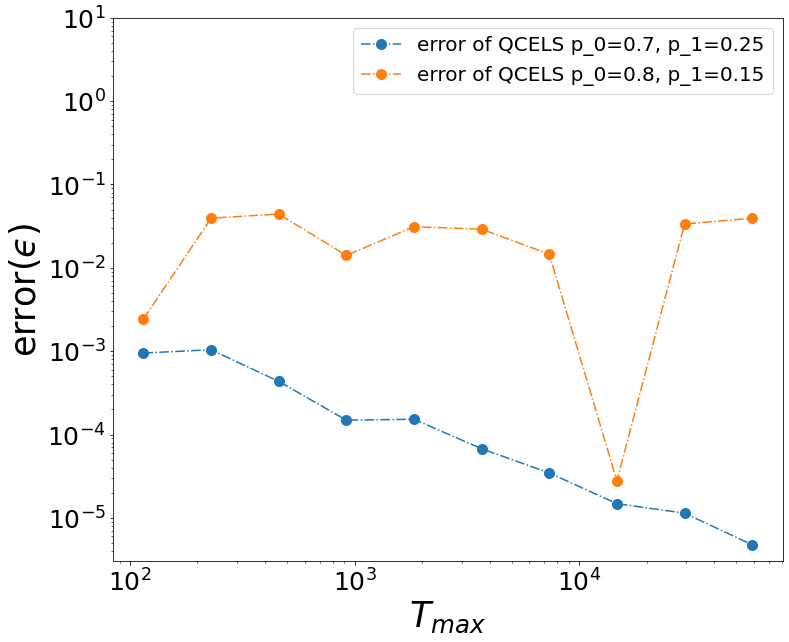

In [12]:
print(rate_success_QCELS)
plt.figure(figsize=(12,10))
plt.plot(max_T_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="o",
         label="error of QCELS p_0={}, p_1={}".format(p0_array[0],p1_array[0]))
# plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",
#          label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(max_T_QCELS[1,:],err_QCELS[1,:],linestyle="-.",marker="o",
         label="error of QCELS p_0={}, p_1={}".format(p0_array[1],p1_array[1]))
# plt.plot(T_list_QPE,err_QPE[1,:],linestyle="-.",marker="*",
#          label="error of QPE p_0={}".format(p0_array[1]))
# plt.plot(max_T_QCELS[0,:],0.06*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.06/T$ scaling")
# plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=20)

In [ ]:
# np.savez('result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,
#          name4=err_QPE)
# np.savez('result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,
#          name4=err_QCELS,name5=p0_array,name6=p1_array)
# np.savez('TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate)